## **ESTABLECIMIENTO DEL DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se prepara el entorno para construir y entrenar modelos de deep learning, específicamente redes neuronales convolucionales (CNN). Para ello, se importan librerías comunes de machine learning, así como las herramientas para crear y entrenar los modelos de deep learning.

In [ ]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import joblib  # For saving and loading model
import time

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets/RML2016.10a.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

Se procede a cargar los datos del archivo PKL que contiene el dataset, para realizar:



*   Extracción de valores de SNR, y de las etiquetas presentes en el diccionario.
*   Se iteran estas combinaciones únicas para construir matrices de caracteríticas (X) y vectores de etquetas (lbl), apilando todos los datos disponibles para cada combinación SNR/Modulación.
*   Se concatena todo en matrices Numpy únicas (X) y (lbl), que contienen todas las muestras disponibles, con sus correspondientes etiquetas.

In [ ]:
Xd = pickle.load(open("/content/data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [ ]:
print(X)

[[[-0.00716379 -0.00241632  0.00063237 ... -0.00422343  0.00362227
    0.00533994]
  [-0.00166505 -0.00144848 -0.01196972 ...  0.00389698 -0.0052103
   -0.0007378 ]]

 [[ 0.00645143 -0.00212428 -0.00706135 ... -0.00565343 -0.00104959
   -0.00529411]
  [ 0.00329197 -0.00067204 -0.00282152 ...  0.00315403 -0.00091081
   -0.00107325]]

 [[ 0.00505826  0.00445021 -0.00706326 ... -0.00086023 -0.00832456
   -0.00439183]
  [ 0.00454194  0.00554406 -0.00336223 ...  0.01007818  0.00437446
    0.00157776]]

 ...

 [[ 0.00090855  0.00091193  0.00096988 ...  0.00087493  0.00092356
    0.00105166]
  [-0.00778397 -0.00787711 -0.00781963 ... -0.00772037 -0.00776644
   -0.00776909]]

 [[ 0.0009345   0.00097915  0.00097718 ...  0.000949    0.0010655
    0.00105054]
  [-0.00771043 -0.00773856 -0.00780745 ... -0.00780556 -0.00772785
   -0.00776188]]

 [[ 0.00091991  0.00093362  0.00092781 ...  0.0009634   0.00095325
    0.00106686]
  [-0.00772773 -0.00768794 -0.00775292 ... -0.00776374 -0.00768772
   -0.

In [ ]:
import pickle
import numpy as np
import codecs

with open('/content/data/RML2016.10a_dict.pkl','rb') as f:
  data = pickle.load(f, encoding='bytes')

print(data)
print(type(data))

{(b'QPSK', 2): array([[[-0.00590147, -0.00234582, -0.00074506, ..., -0.00326824,
         -0.00304144,  0.00569031],
        [-0.00779554, -0.00781637, -0.00401967, ...,  0.01032196,
          0.00841506,  0.00544548]],

       [[ 0.00503262,  0.0009438 , -0.00189324, ...,  0.00710436,
          0.00647364,  0.00527375],
        [-0.00399943,  0.00161782,  0.00536932, ..., -0.00674945,
          0.00022403, -0.00185736]],

       [[ 0.00523907,  0.00738907,  0.00727646, ..., -0.00567421,
         -0.00974218, -0.01044694],
        [ 0.00419956,  0.0073807 ,  0.00528897, ..., -0.00246656,
          0.00416547, -0.00496793]],

       ...,

       [[ 0.0026172 ,  0.00298624,  0.00437732, ..., -0.00955281,
         -0.00808954, -0.00061479],
        [ 0.00322034,  0.00341152,  0.00447983, ...,  0.00353227,
          0.00287296,  0.00412169]],

       [[-0.00764636, -0.00967675, -0.00678905, ..., -0.00210244,
         -0.00629975, -0.00922944],
        [ 0.00805844,  0.00562819,  0.00702108

## **CONJUNTOS DE ENTRENAMIENTO Y PRUEBAS**

A continuación, se particionan los datos X previamente preparados en conjuntos de entrenamiento (train) y prueba (test) para poder entrenar y evaluar el modelo a configurar más adelante.

*   Se establece una semilla aleatoria para asegurar reproducibilidad.
*   Se calcula el número total de ejemplos/muestras en X.
*   Se define el tamaño del conjunto de entrenamiento a un 50% del total de los datos.
*   Se seleccionan aleatoriamente los índices que formarán parte del conjunto de entrenamiento.
*   El conjunto de prueba se calcula como los indices restantes.
*   Se indexa la matriz X para obtener las matrices X_train y X_test separadas.


Esto es paso permite tener datos independientes de entrenamiento y prueba para entrenar modelos y evaluar su desempeño sobre datos nunca antes vistos. La proporción es 50/50 train/test.

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [ ]:
print(train_idx)
print(test_idx)
print(X_train.shape)
print(X_test.shape)

[ 40917 196793  21915 ...  30900 138950 196208]
[0, 1, 2, 6, 9, 10, 13, 14, 15, 20, 21, 24, 25, 26, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 42, 44, 48, 50, 52, 53, 54, 56, 58, 60, 61, 63, 64, 65, 68, 70, 73, 75, 76, 80, 82, 83, 90, 92, 95, 98, 100, 102, 104, 105, 106, 108, 109, 111, 116, 119, 121, 122, 126, 127, 128, 129, 132, 133, 136, 137, 142, 143, 145, 146, 150, 154, 155, 156, 157, 158, 162, 164, 166, 168, 169, 170, 171, 172, 175, 177, 178, 179, 184, 187, 188, 190, 192, 193, 194, 195, 196, 197, 199, 200, 207, 210, 211, 212, 213, 214, 218, 219, 220, 221, 223, 227, 228, 229, 230, 231, 233, 236, 239, 241, 242, 244, 247, 249, 250, 252, 253, 255, 257, 259, 262, 264, 265, 266, 267, 268, 269, 275, 277, 279, 280, 281, 282, 283, 284, 286, 287, 288, 290, 291, 292, 293, 294, 296, 297, 298, 299, 300, 301, 307, 309, 310, 313, 316, 317, 322, 323, 324, 328, 329, 330, 332, 334, 336, 337, 338, 342, 343, 345, 347, 350, 353, 354, 355, 357, 358, 359, 360, 361, 362, 363, 365, 366, 368, 369, 370, 371, 3

## **VECTORES BINARIOS PARA CADA CLASE, CON CODIFICACIÓN ONE-HOT**

In [ ]:
#one-hot encoding the label
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [ ]:
print(lbl_encoded)
print(y_train.shape)
print(y_test.shape)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(110000, 11)
(110000, 11)


Se obtienen las dimensiones de las muestras de entrenamiento, exceptuando la primera dimensión que corresponde al número de ejemplos. Así se tiene la forma de una sola muestra de entrada al modelo (sin batch size).

In [ ]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [ ]:
np.max(X_train), np.min(X_train)

(0.16422912, -0.11944099)

## **CONSTRUCCIÓN DEL MODELO DE RED NEURONAL**

 Se define la arquitectura de un modelo de red neuronal convolucional mediante KERAS.
 Este modelo se construye de forma secuencial.
* Se tienen capas convolucionales 2D que detectan patrones locales en las señales de entrada gracias a los filtros (kernels) que se deslizan sobre la señal. Cada capa convolucional activa distintas características o features que luego son clasificados.
*   Luego de extraer features, se agregan capas densas totalmente conectadas al final para tomar estas características activadas por las convoluciones, y mediante sus pesos asignar probabilidades a cada clase posible.
*   Entremedio tienen capas como max pooling, aplanado, normalización batch y dropout que ayudan al entrenamiento y generalización.

Finalmente se compila el modelo para entrenamiento definiendo función de pérdida, optimizador y métricas.

In [ ]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp + [1], input_shape = in_shp))

model.add(Conv2D(64, (1, 3), activation ='relu'))
model.add(Dropout(dr))

model.add(Conv2D(16, (2, 3), activation ='relu'))
model.add(Dropout(dr))

#model.add(Conv2D(16, (1, 4), activation ='relu'))
#model.add(Dropout(dr))

model.add(Flatten())
model.add(Dense(512, activation ='relu')) # 128
model.add(Dropout(dr))

model.add(Dense(128, activation ='relu')) # 128
model.add(Dropout(dr))

model.add(Dense(len(classes), activation ='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 2, 128, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 126, 64)        256       
                                                                 
 dropout_13 (Dropout)        (None, 2, 126, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 1, 124, 16)        6160      
                                                                 
 dropout_14 (Dropout)        (None, 1, 124, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 1984)              0         
                                                                 
 dense_6 (Dense)             (None, 512)             

## **ENTRENAMIENTO DEL MODELO**

Se entrena modelo de red neuronal convolucional previamente definido, utilizando los datos de entrenamiento (X_train, y_train):

* Se inicia un timer para medir el tiempo total de entrenamiento.
* Se llama al método .fit() de Keras para entrenar por lotes (batch size) durante número determinado de épocas (epochs).
* Se imprimen logs durante el entrenamiento para monitorizar.
* Se evalúa el desempeño en los datos de validación (X_test, y_test) después de cada época para monitorear overfitting.
* Usa EarlyStopping como callback para detener el entrenamiento si no hay mejora en los de valores de pérdida de validación después de 10 épocas (en este caso).
* Una vez terminado el entrenamiento, se imprime el tiempo total.

In [ ]:

tic = time.time()
history = model.fit(X_train, y_train, batch_size = 1024, epochs = 50, verbose = 1, validation_data = (X_test, y_test),
                    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1,
                                               mode = 'auto', restore_best_weights = True)])
toc = time.time()
training_time = toc - tic

print ("The training time is %.3f seconds" %(training_time))

Epoch 1/50
108/108 [==============================] - 3s 30ms/step - loss: 1.3882 - accuracy: 0.4647 - val_loss: 1.3089 - val_accuracy: 0.4796
Epoch 2/50
108/108 [==============================] - 3s 25ms/step - loss: 1.3762 - accuracy: 0.4685 - val_loss: 1.3363 - val_accuracy: 0.4834
Epoch 3/50
108/108 [==============================] - 3s 32ms/step - loss: 1.3713 - accuracy: 0.4714 - val_loss: 1.3158 - val_accuracy: 0.4865
Epoch 4/50
108/108 [==============================] - 3s 28ms/step - loss: 1.3617 - accuracy: 0.4740 - val_loss: 1.2857 - val_accuracy: 0.4934
Epoch 5/50
108/108 [==============================] - 3s 27ms/step - loss: 1.3554 - accuracy: 0.4759 - val_loss: 1.2822 - val_accuracy: 0.4986
Epoch 6/50
108/108 [==============================] - 3s 26ms/step - loss: 1.3466 - accuracy: 0.4769 - val_loss: 1.3039 - val_accuracy: 0.4943
Epoch 7/50
108/108 [==============================] - 3s 25ms/step - loss: 1.3388 - accuracy: 0.4803 - val_loss: 1.2721 - val_accuracy: 0.5036

## **EVALUAR Y GRAFICAR EL RENDIMIENTO DEL MODELO**

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=1024)
# score = model.evaluate(X_test_pca, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

108/108 [==============================] - 1s 6ms/step - loss: 1.2149 - accuracy: 0.5304
Test loss: 1.214922547340393
Test accuracy: 0.5303545594215393


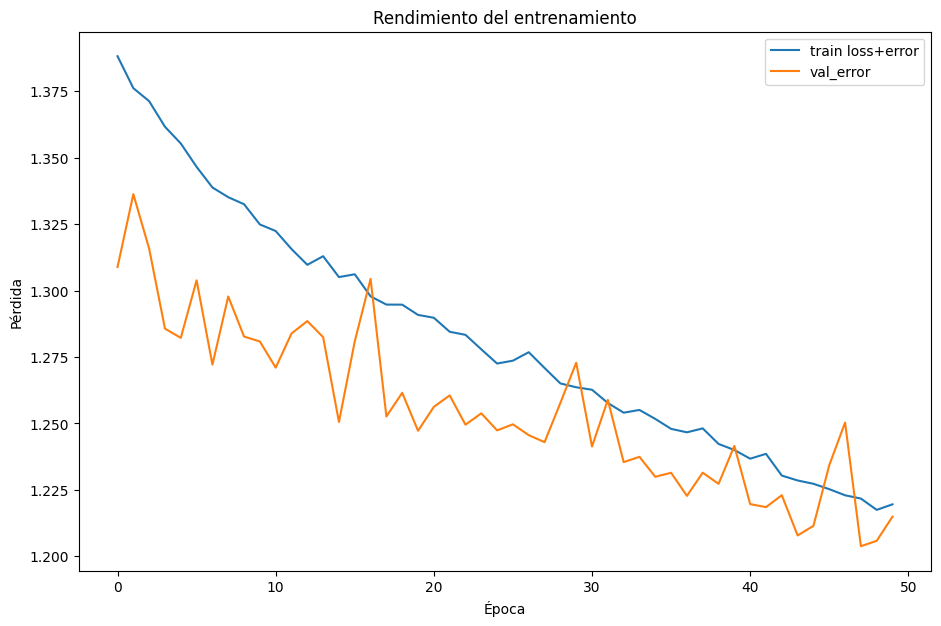

In [ ]:
# Show loss curves
plt.figure(figsize = (11, 7))
plt.title('Rendimiento del entrenamiento')
plt.plot(history.epoch, history.history['loss'], label = 'train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_predict = model.predict(X_test)
y_predict_classes = np.argmax(y_predict, axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_predict_classes))

3438/3438 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.53      0.50      0.51     10109
           1       0.54      0.69      0.61      9859
           2       0.25      0.97      0.40      9969
           3       0.84      0.61      0.71      9994
           4       0.85      0.61      0.71      9968
           5       0.82      0.62      0.71      9986
           6       0.96      0.64      0.77      9992
           7       0.48      0.15      0.23     10029
           8       0.55      0.59      0.57      9992
           9       0.63      0.31      0.42     10028
          10       0.71      0.16      0.26     10074

    accuracy                           0.53    110000
   macro avg       0.65      0.53      0.53    110000
weighted avg       0.65      0.53      0.53    110000



In [ ]:
from sklearn.metrics import classification_report
y_predict = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict, axis = 1)))

3438/3438 [==============================] - 7s 2ms/step
              precision    recall  f1-score   support

           0       0.35      0.16      0.22     10109
           1       0.53      0.66      0.59      9859
           2       0.24      0.98      0.39      9969
           3       0.78      0.59      0.67      9994
           4       0.67      0.57      0.61      9968
           5       0.74      0.60      0.67      9986
           6       0.98      0.56      0.71      9992
           7       0.49      0.12      0.20     10029
           8       0.57      0.52      0.54      9992
           9       0.39      0.35      0.37     10028
          10       0.57      0.15      0.23     10074

    accuracy                           0.48    110000
   macro avg       0.57      0.48      0.47    110000
weighted avg       0.57      0.48      0.47    110000



## **MATRIZ DE CONFUSIÓN**

Se grafica la matriz de confusión para el modelo clasificador previamente entrenado y evaluado. Esta matriz permite analizar en detalle el desempeño del modelo al mostrar la cantidad de casos por clase que fueron bien o mal clasificados.

108/108 [==============================] - 1s 6ms/step


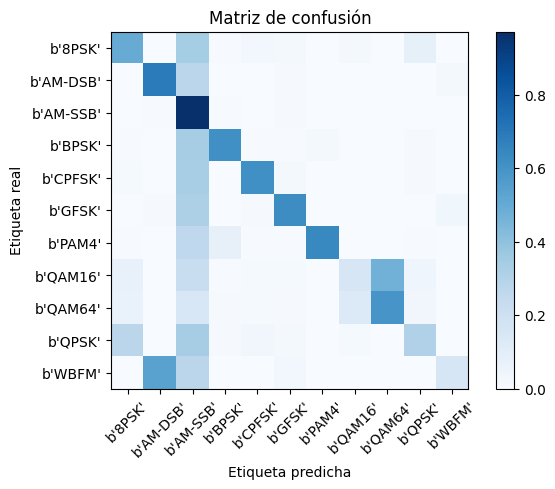

In [ ]:
def plot_confusion_matrix(cm, title='Matriz de confusión', cmap = plt.cm.Blues, labels = []):
#     plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
def confusion_matrix(model, classes, X_test, y_test):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plot_confusion_matrix(confnorm, labels = classes)

# GRAFICAR LA MATRIZ DE CONFUSION
confusion_matrix(model, classes, X_test, y_test)

Dado que se tienen más niveles de SNR, se debe acomodar el siguiente snippet apuntando a los elementos de la matriz "temp_array". Esto permite evaluar si el desempeño del modelo se degrada para ciertos niveles de ruido.

In [ ]:
## Obtener la precisión de la prueba para diferentes SNRs
def getTestAccArray(model, lbl, X_test, y_test, test_idx):
    acc = []

    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
#         test_SNRs = map(lambda x: lbl[x][1], test_idx)
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])

        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1

        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, title="Matriz de confusión ConvNet (SNR=%d)"%(SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Precisión general:", cor / (cor+ncor),"para SNR",snr)
#         acc[snr] = 1.0*cor/(cor+ncor)
        acc.append(1.0*cor/(cor+ncor))

    return acc

171/171 [==============================] - 0s 2ms/step
Precisión general: 0.09368709972552608 para SNR b'-20'
173/173 [==============================] - 1s 3ms/step
Precisión general: 0.09118982742960945 para SNR b'-18'
173/173 [==============================] - 1s 3ms/step
Precisión general: 0.09099131693198263 para SNR b'-16'
174/174 [==============================] - 1s 3ms/step
Precisión general: 0.09256586070010826 para SNR b'-14'
172/172 [==============================] - 0s 3ms/step
Precisión general: 0.10920692798541477 para SNR b'-12'
176/176 [==============================] - 1s 3ms/step
Precisión general: 0.164385996090279 para SNR b'-10'
171/171 [==============================] - 0s 2ms/step
Precisión general: 0.3408047032886276 para SNR b'-8'
171/171 [==============================] - 0s 2ms/step
Precisión general: 0.5441715542521994 para SNR b'-6'
170/170 [==============================] - 0s 2ms/step
Precisión general: 0.6730129390018484 para SNR b'-4'
173/173 [=========

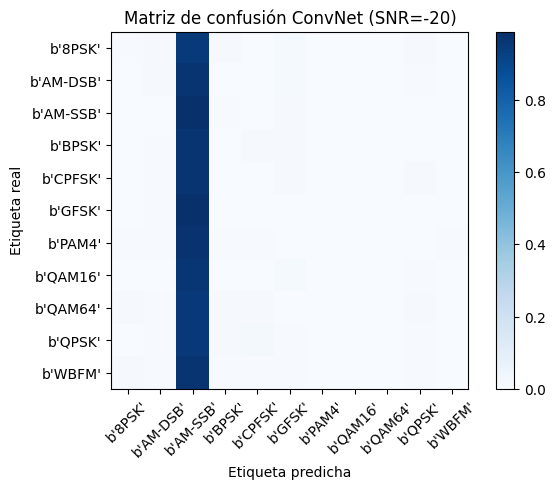

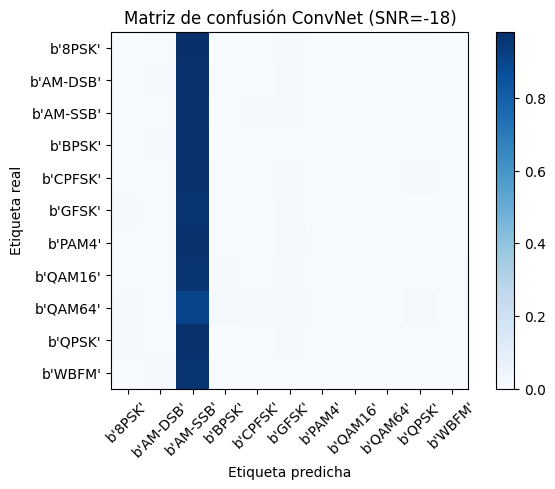

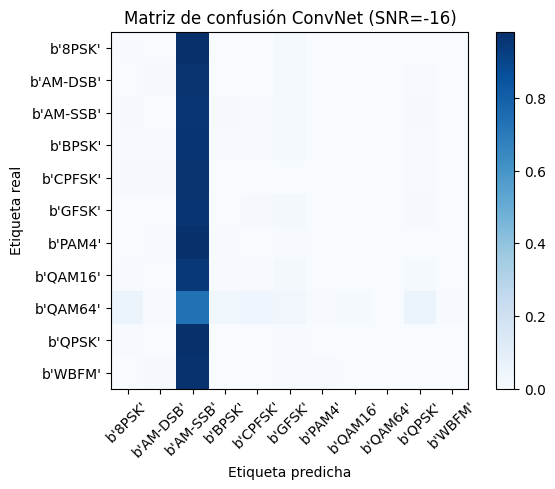

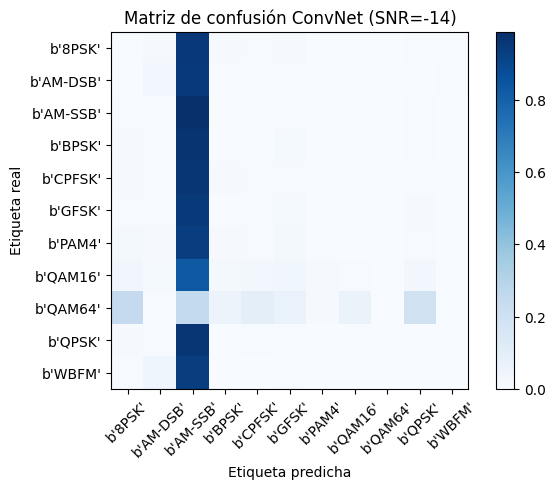

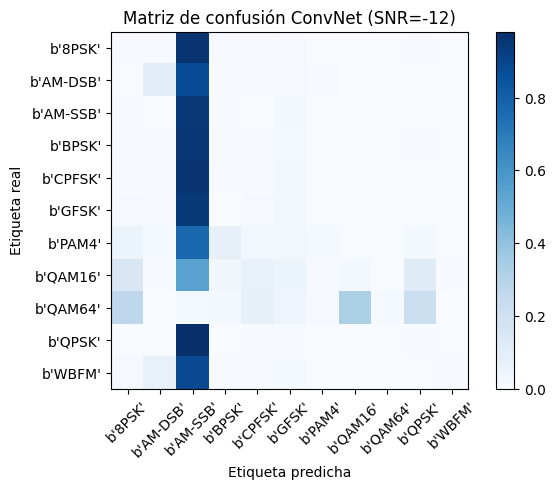

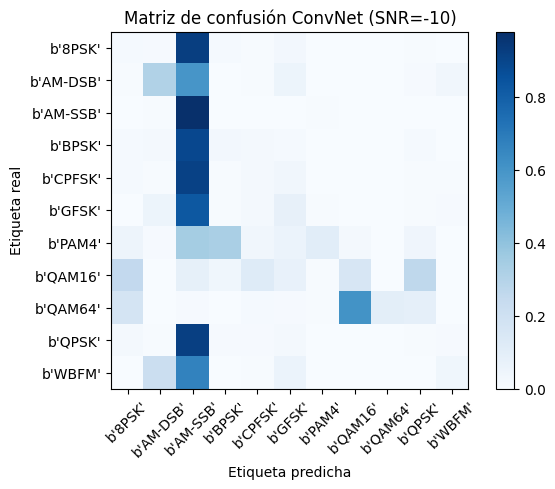

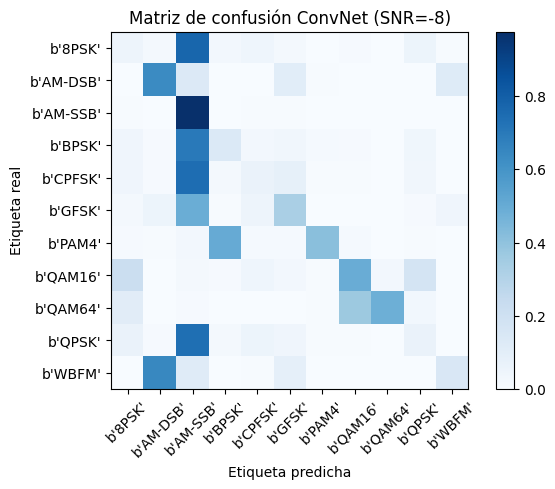

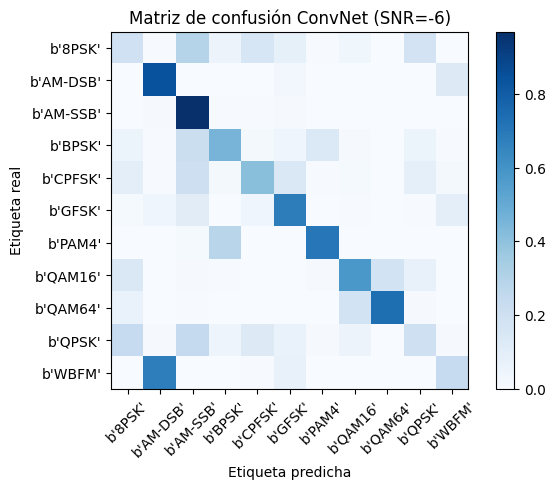

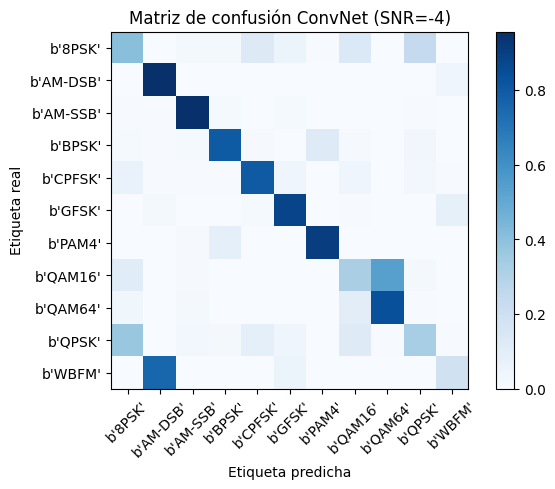

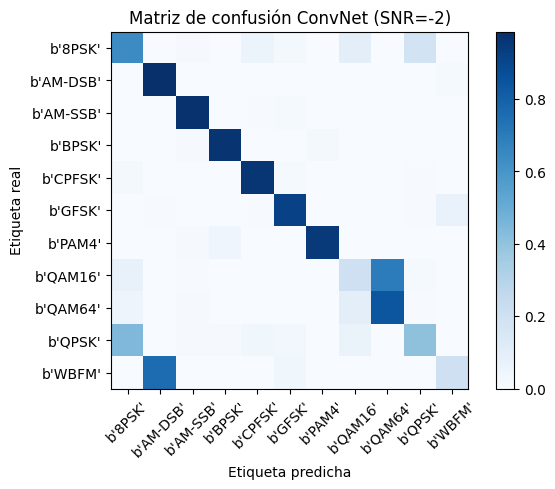

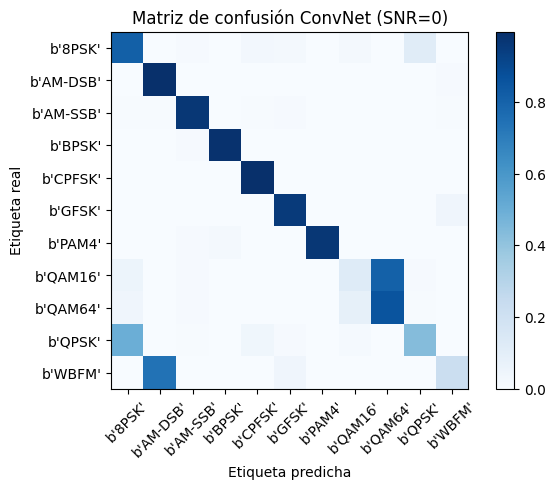

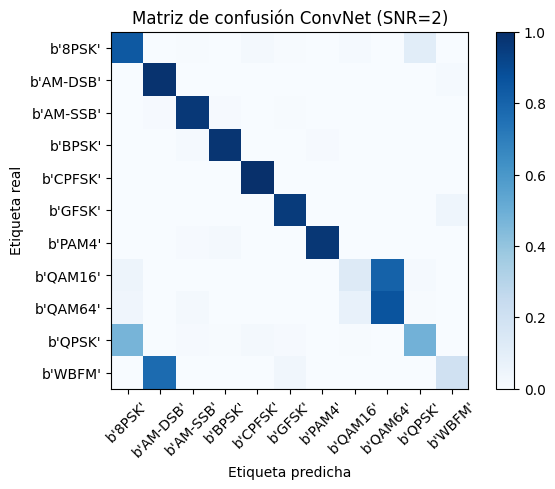

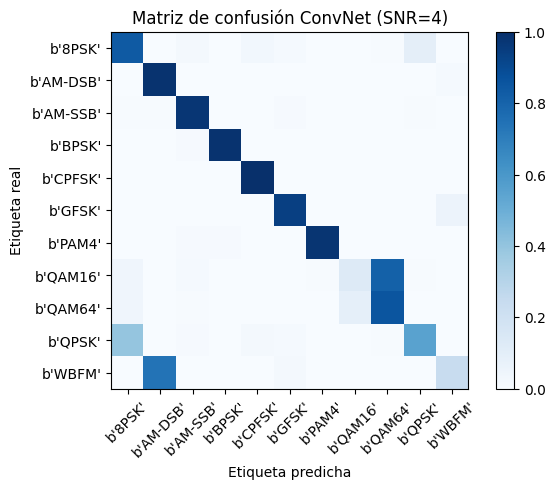

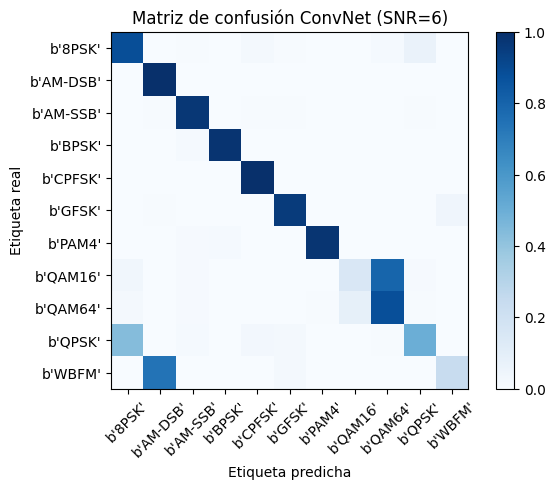

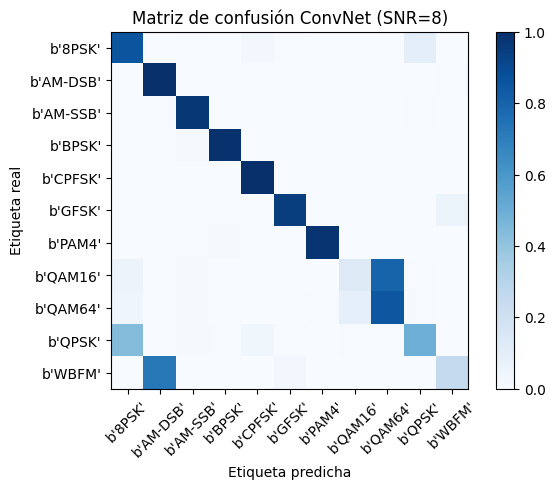

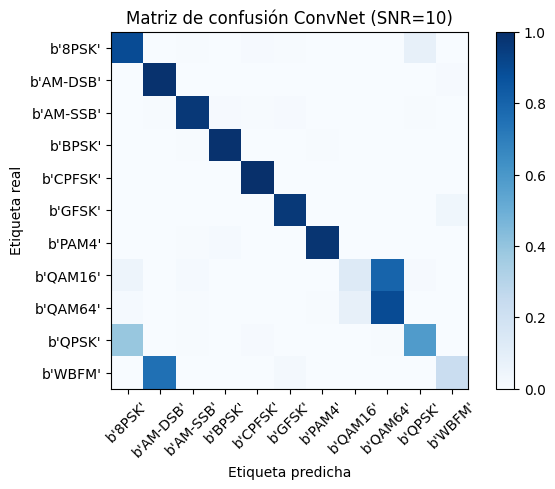

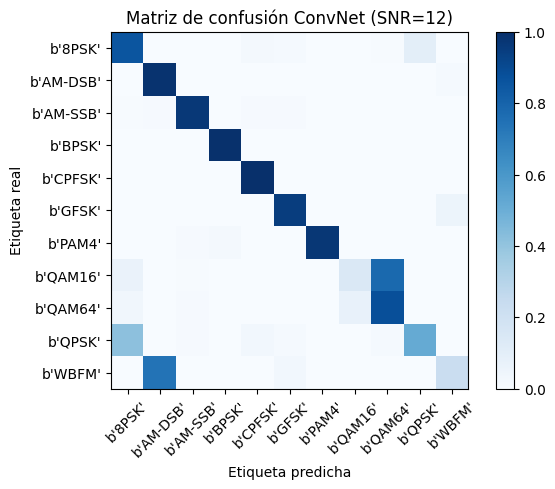

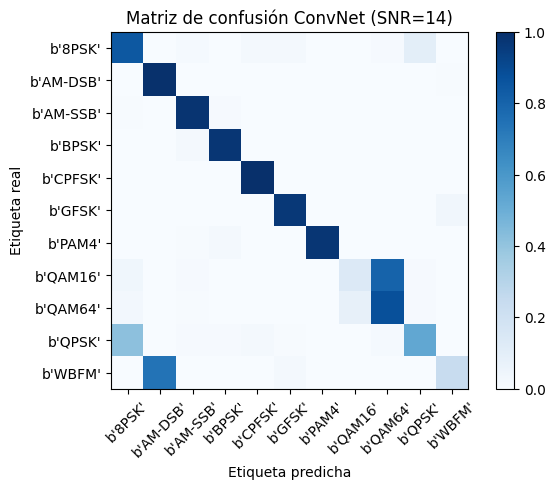

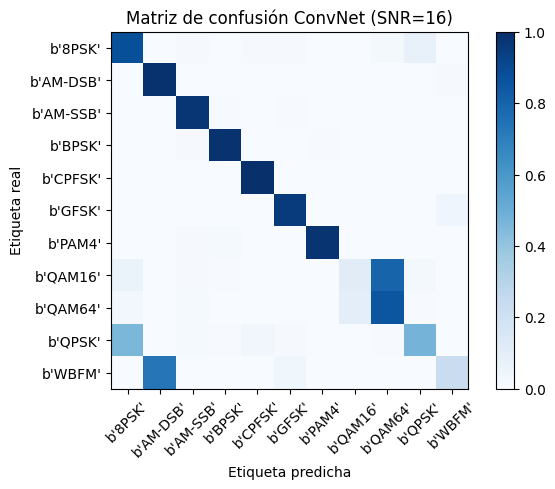

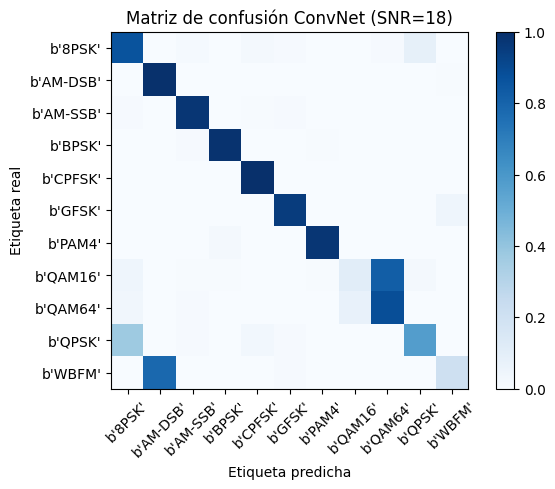

In [ ]:
acc = getTestAccArray(model, lbl, X_test, y_test, test_idx)

Text(0.5, 1.0, 'Precisión vs SNR')

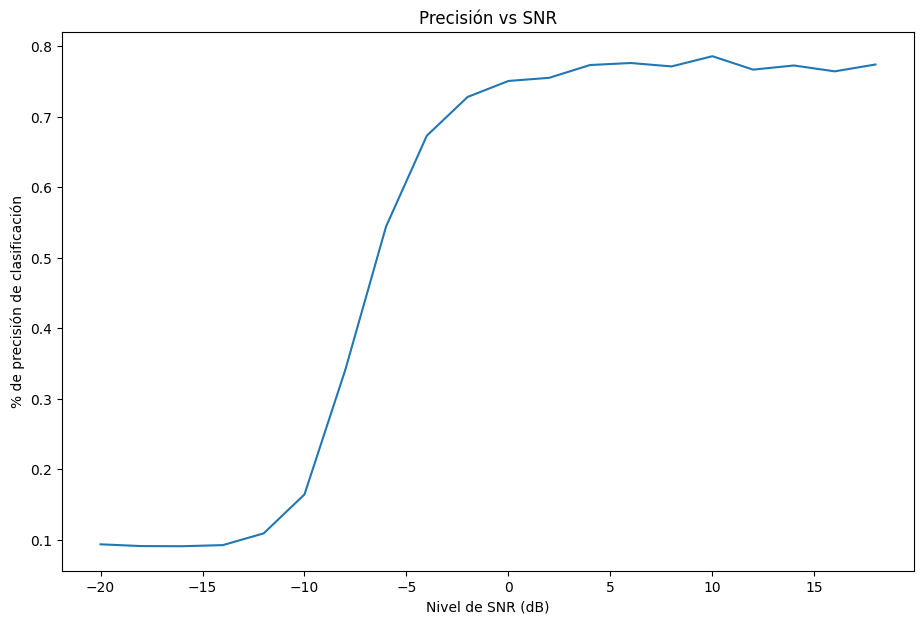

In [ ]:
# Plot accuracy curve
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc)
plt.xlabel("Nivel de SNR (dB)")
plt.ylabel("% de precisión de clasificación")
plt.title('Precisión vs SNR')